In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Jupyter magic command (ensures inline graphs in notebook)
%matplotlib inline
sns.set_style("whitegrid")

# --- Step 2: Load Dataset ---
df = pd.read_csv("/content/supply_chain_data.csv")

# Rename target variable (HistoricalSales = Demand proxy)
df = df.rename(columns={'Number of products sold': 'HistoricalSales'})
target_column = "HistoricalSales"

print("--- Initial Data Snapshot ---")
display(df.head())

--- Initial Data Snapshot ---


,Product type,SKU,Price,Availability,HistoricalSales,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


/tmp/ipython-input-3412529178.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_product.index, y=revenue_by_product.values, palette='viridis')


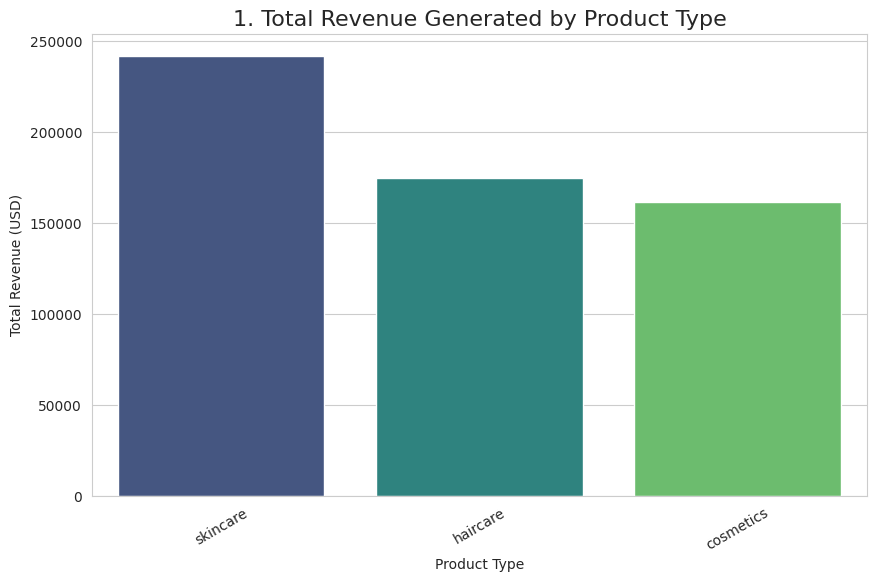

/tmp/ipython-input-3412529178.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=costs_by_transport.index, y=costs_by_transport.values, palette='plasma')


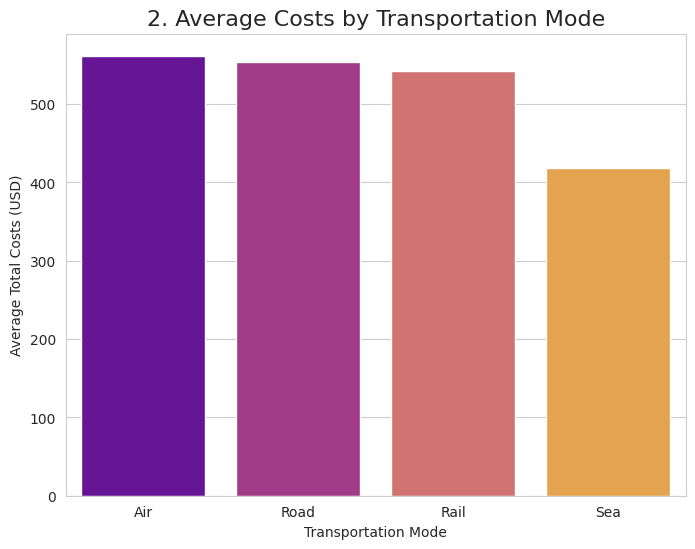

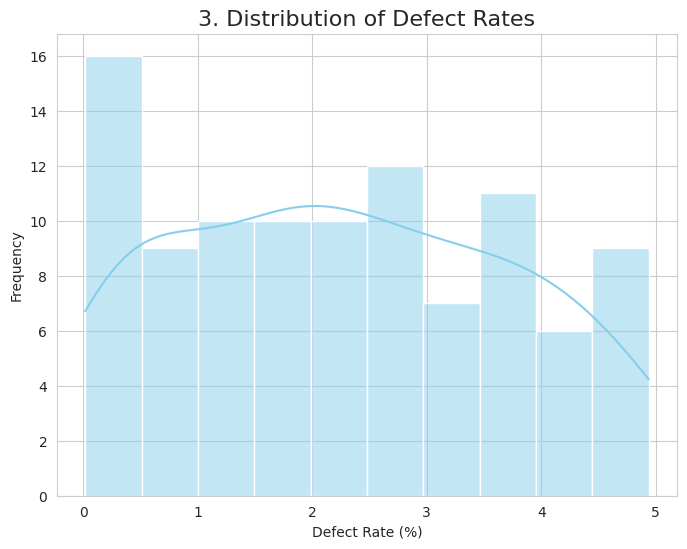

In [8]:
# --- Step 3: Exploratory Data Analysis (Graphs) ---

# Graph 1: Total Revenue by Product Type
revenue_by_product = df.groupby('Product type')['Revenue generated'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_product.index, y=revenue_by_product.values, palette='viridis')
plt.title('1. Total Revenue Generated by Product Type', fontsize=16)
plt.xlabel('Product Type')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=30)
plt.show()

# Graph 2: Average Costs by Transportation Mode
costs_by_transport = df.groupby('Transportation modes')['Costs'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=costs_by_transport.index, y=costs_by_transport.values, palette='plasma')
plt.title('2. Average Costs by Transportation Mode', fontsize=16)
plt.xlabel('Transportation Mode')
plt.ylabel('Average Total Costs (USD)')
plt.show()

# Graph 3: Distribution of Defect Rates
plt.figure(figsize=(8, 6))
sns.histplot(df['Defect rates'], bins=10, kde=True, color='skyblue')
plt.title('3. Distribution of Defect Rates', fontsize=16)
plt.xlabel('Defect Rate (%)')
plt.ylabel('Frequency')
plt.show()


In [9]:
# --- Step 4: Data Preprocessing ---

# Drop redundant columns
df = df.drop(columns=['SKU', 'Lead time'])

# One-hot encode categorical variables
categorical_cols = [
    'Product type', 'Customer demographics', 'Shipping carriers',
    'Supplier name', 'Location', 'Inspection results',
    'Transportation modes', 'Routes'
]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Features and target
X = df.drop(columns=[target_column, 'Revenue generated'])
y = df[target_column]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n--- Data Preprocessing Complete ---")
print(f"Features used for training: {X_train.shape[1]}")


--- Data Preprocessing Complete ---
Features used for training: 34


--- Starting Model Training (50 Epochs) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Model Training Complete ---


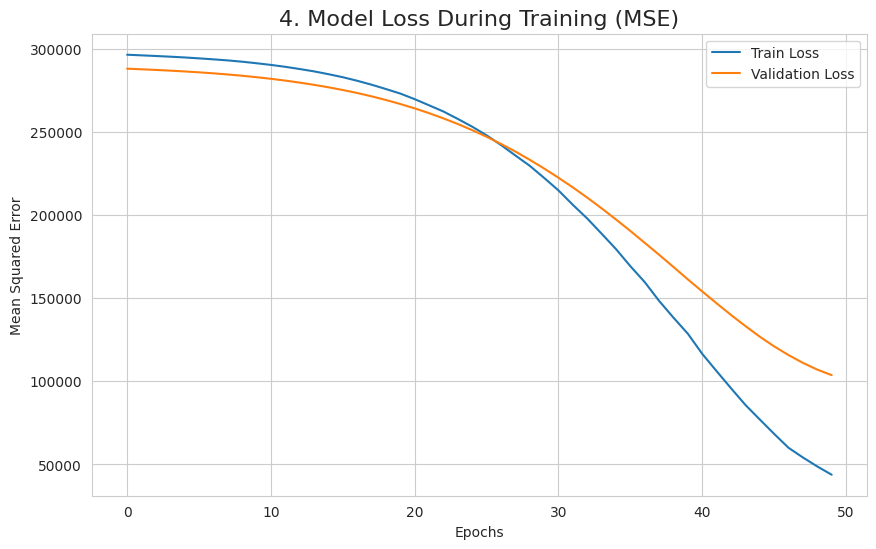

In [10]:
# --- Step 5: Model Building ---

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[X_train_scaled.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

print("--- Starting Model Training (50 Epochs) ---")
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    validation_split=0.2,
    verbose=0
)
print("--- Model Training Complete ---")

# Graph 4: Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('4. Model Loss During Training (MSE)', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

Mean Squared Error (MSE) on Test Set: 126174.79
Root Mean Squared Error (RMSE) on Test Set: 355.21


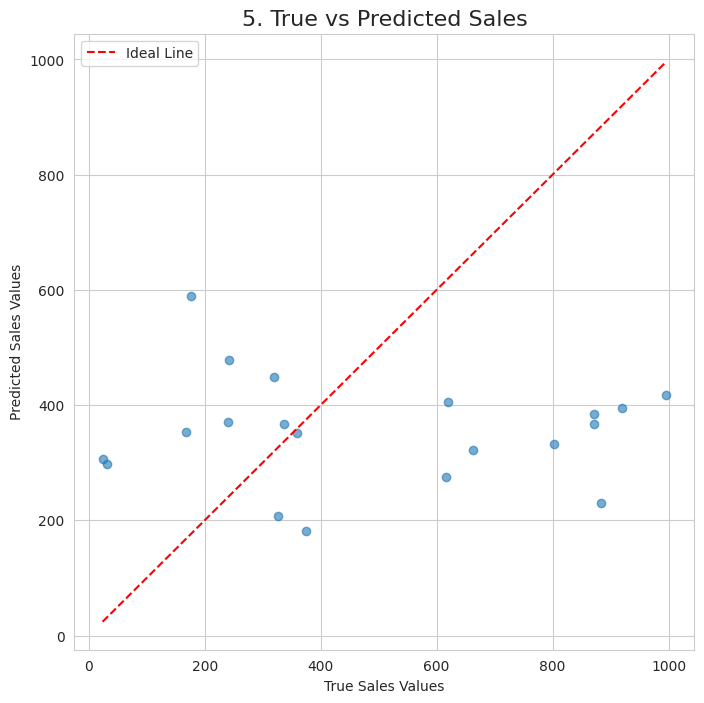

Model saved as demand_forecasting_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

--- Example Prediction ---
Predicted Sales: 184.72

--- Supply Chain Management Demand Forecasting Report ---
Objective: Forecast product demand using ML (Neural Network)
Model Performance: RMSE on Test Set = 355.21
Graphs: Revenue by Product, Costs by Transport, Defect Rates, Loss Curves, True vs Predicted Sales
Conclusion: Model provides a baseline demand forecasting tool to optimize supply chain decisions.


In [11]:
# --- Step 6: Model Evaluation ---

test_predictions = model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

print(f'\nMean Squared Error (MSE) on Test Set: {mse:.2f}')
print(f'Root Mean Squared Error (RMSE) on Test Set: {rmse:.2f}')

# Graph 5: True vs Predicted Sales
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_predictions, alpha=0.6)
max_val = max(y_test.max(), test_predictions.max())
min_val = min(y_test.min(), y_test.max()) # Corrected min_val calculation
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Line')
plt.title('5. True vs Predicted Sales', fontsize=16)
plt.xlabel('True Sales Values')
plt.ylabel('Predicted Sales Values')
plt.legend()
plt.show()

# --- Step 7: Model Deployment ---

model.save("demand_forecasting_model.keras") # Changed file extension to .keras
print("Model saved as demand_forecasting_model.keras")

# Reload and test with synthetic example
loaded_model = keras.models.load_model("demand_forecasting_model.keras") # Changed file extension to .keras

example_data_raw = {col: [X.mean()[col]] if X.dtypes[col] != 'uint8' else [0]
                    for col in X.columns}
example_data_raw['Price'] = [70.0]
example_data_raw['Production volumes'] = [900]
example_data_raw['Manufacturing costs'] = [50.0]
if 'Product type_Skincare' in example_data_raw:
    example_data_raw['Product type_Skincare'] = [1]

new_data_df = pd.DataFrame(example_data_raw)
new_data_scaled = scaler.transform(new_data_df)
predicted_sales = loaded_model.predict(new_data_scaled)

print(f"\n--- Example Prediction ---")
print(f"Predicted Sales: {predicted_sales[0][0]:.2f}")

# --- Final Report Summary ---
print("\n--- Supply Chain Management Demand Forecasting Report ---")
print(f"Objective: Forecast product demand using ML (Neural Network)")
print(f"Model Performance: RMSE on Test Set = {rmse:.2f}")
print("Graphs: Revenue by Product, Costs by Transport, Defect Rates, Loss Curves, True vs Predicted Sales")
print("Conclusion: Model provides a baseline demand forecasting tool to optimize supply chain decisions.")